In [20]:
%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%matplotlib inline
%autoreload 1
import pickle
import numpy as np
from functools import partial
import MDAnalysis

from pathlib import Path

import matplotlib.pyplot as plt
import numpy.typing as npt

import pandas as pd

from scipy import integrate, interpolate, stats
from scipy.optimize import curve_fit
from tqdm.auto import tqdm
from tqdm.contrib.concurrent import process_map

%aimport util
from plot_helper import *


In [22]:
plot_styles = [
    ("./white_background_ctl.mplstyle", ""),
    ("./dark_background_ctl.mplstyle", "_dark"),
]


In [23]:
def get_compositions(sim):
    top = util.sim_path / str(sim) / "system.top"
    
    
    raw_composition = {}
    with open(top, 'r') as fd:
        molecules_flag = False
        for line in fd:
            if molecules_flag:
                line = line.split(";")[0]
                if line:
                    r, n = line.split()
                    if r in raw_composition:
                        raw_composition[r] += int(n)
                    else:
                        raw_composition[r] = int(n)
            else:
                if "[ molecules ]" in line:
                    molecules_flag = True

    total_lipids = 0
    for lipid in util.lipid_names:
        if lipid in raw_composition:
            total_lipids += raw_composition[lipid]

    normed_composition = {}
    s = ""
    for lipid in util.lipid_names:
        if lipid in raw_composition:
            s += f"{lipid}: {raw_composition[lipid]/total_lipids:0.2f}; "
            normed_composition[lipid] = raw_composition[lipid] / total_lipids
        else:
            s += f"{lipid}: {0:0.2f}; "
            normed_composition[lipid] = 0
    print(util.sim_to_final_index[sim], "total lipids", total_lipids)
    return sim, raw_composition, normed_composition, s


result = map(get_compositions, util.simulations)

compositions = {}
for sim, raw, normed, s in result:
    print(f"System {util.sim_to_final_index[sim]}: {s}")
    print(f"    {raw}")
    compositions[sim, "raw_composition"] = raw
    compositions[sim, "normed_composition"] = normed


1 total lipids 5404
System 1: DOPG: 0.00; POPE: 0.03; POPG: 0.00; CDL2: 0.00; CDL1: 0.12; DOPC: 0.46; DOPE: 0.27; POPC: 0.12; 
    {'POPC': 648, 'DOPC': 2486, 'POPE': 162, 'DOPE': 1460, 'CDL1': 648, 'W': 259935, 'NA': 3186, 'CL': 2538}
2 total lipids 5406
System 2: DOPG: 0.00; POPE: 0.08; POPG: 0.00; CDL2: 0.00; CDL1: 0.12; DOPC: 0.25; DOPE: 0.29; POPC: 0.26; 
    {'POPC': 1406, 'DOPC': 1352, 'POPE': 432, 'DOPE': 1568, 'CDL1': 648, 'W': 259965, 'NA': 3186, 'CL': 2538}
-3 total lipids 5402
System -3: DOPG: 0.00; POPE: 0.14; POPG: 0.00; CDL2: 0.00; CDL1: 0.12; DOPC: 0.22; DOPE: 0.18; POPC: 0.34; 
    {'POPC': 1838, 'DOPC': 1188, 'POPE': 756, 'DOPE': 972, 'CDL1': 648, 'W': 259989, 'NA': 3186, 'CL': 2538}
7 total lipids 5404
System 7: DOPG: 0.05; POPE: 0.02; POPG: 0.06; CDL2: 0.00; CDL1: 0.00; DOPC: 0.55; DOPE: 0.22; POPC: 0.10; 
    {'POPC': 540, 'DOPC': 2974, 'POPE': 108, 'DOPE': 1188, 'POPG': 324, 'DOPG': 270, 'W': 260922, 'NA': 3170, 'CL': 2576}
8 total lipids 5404
System 8: DOPG: 0.02

In [24]:
from neighbor_analysis import lipids

pd.options.display.float_format = "{:.3f}".format

# Lipids in order in results matrix
lipid_dict = dict([[j, i] for i, j in enumerate(lipids)])
leaflets = ["upper", "lower"]


def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


def print_neighbor_analysis(dataset, prefix=""):
    for sim in util.simulations:
        print(f"System {util.sim_to_final_index[sim]}: {util.system_names[sim]}")

        raw_baseline = []
        baseline = []
        s = ""
        for lipid in lipids:
            if lipid in compositions[sim, "raw_composition"]:
                # div by 2 to account for leaflet composition
                raw_baseline.append(compositions[sim, "raw_composition"][lipid] / 2)
            else:
                raw_baseline.append(0)
            s += f"{lipid}: {compositions[sim, 'normed_composition'][lipid]:0.3f}, "
            baseline.append(compositions[sim, "normed_composition"][lipid])
        raw_baseline = np.array(raw_baseline).reshape(-1, 1)  # COLUMN VECTOR
        print(s)
        # fraction of each lipid per leaflet
        baseline = np.array(baseline)
        # print(raw_baseline, baseline)

        # Aggregate statistics from both leaflets
        counts_per_frame = (dataset[sim]["upper"] + dataset[sim]["lower"]) / 2
        # Keep only back half of trajectory
        N = int(0.5 * len(counts_per_frame))
        counts = np.mean(counts_per_frame[N:-1], axis=0)  # mean counts per frame

        # Copy counts across diagonal which must be symmetric
        for i in range(0, len(lipids)):
            for j in range(0, i):
                counts[i, j] = counts[j, i]
            counts[i, i] *= 2
        counts /= 2

        # print(pd.DataFrame(counts, columns=lipids, index=lipids))

        # Normalize by number of each lipid within leaflet
        # ROWWISE DIVISION...
        normed_counts = np.divide(
            counts, raw_baseline, out=np.zeros_like(counts), where=raw_baseline != 0
        )
        df_normed_counts = pd.DataFrame(normed_counts, columns=lipids, index=lipids)
        df_normed_counts.to_csv(f"sheets/sim_{util.sim_to_final_index[sim]}_nlipids_{prefix}.csv")

        print("# of each lipid around row lipid\n", df_normed_counts)

        rowwise_sum = np.sum(normed_counts, axis=1).reshape(-1, 1)
        # print(np.array2string(rowwise_sum, max_line_width=np.inf))

        likelihood_count = np.divide(
            normed_counts,
            rowwise_sum,
            out=np.zeros_like(counts),
            where=rowwise_sum != 0,
        )

        # print(np.array2string(likelihood_count, max_line_width=np.inf))

        diff_counts = np.divide(
            likelihood_count,
            baseline,
            out=np.zeros_like(normed_counts),
            where=baseline != 0,
        )
        # df = pd.DataFrame(normed_counts, columns=lipids, index=lipids)
        # print(df)

        # print("DIFF:")
        df_diff = pd.DataFrame(pd.DataFrame(diff_counts, columns=lipids, index=lipids))

        df_diff.to_csv(f"sheets/sim_{util.sim_to_final_index[sim]}_likelihood_{prefix}.csv")

        print("Enrichment from likelihood:\n", df_diff)
        print()


In [25]:
neighbor_enrichment = {}

for sim in util.simulations:
    with open(
        util.analysis_path / f"{sim}/neighbor_enrichment_leaflet_glo.pickle", "rb"
    ) as handle:
        neighbor_enrichment[sim] = pickle.load(handle)


In [26]:
def highlight_cell(x, y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1, 1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect


In [40]:
import cmasher as cmr


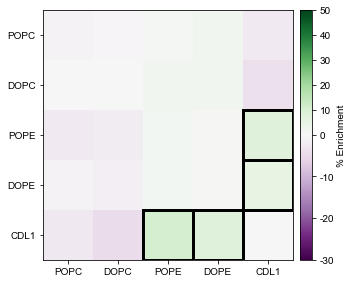

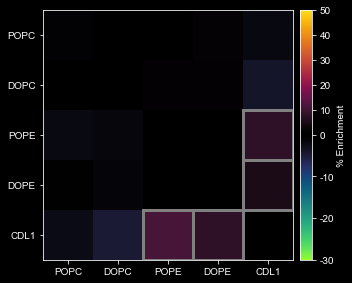

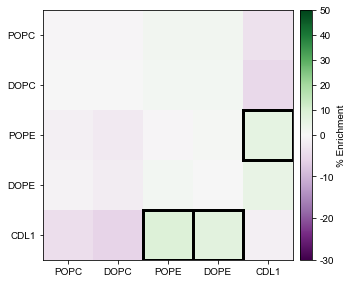

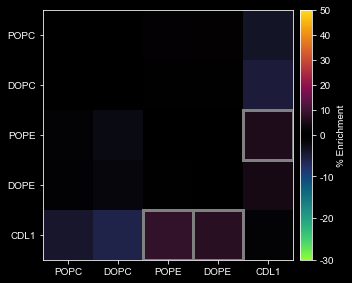

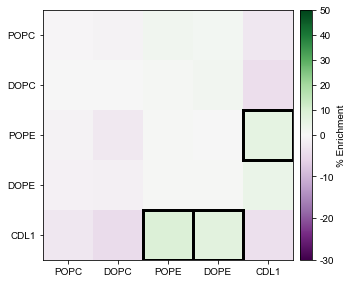

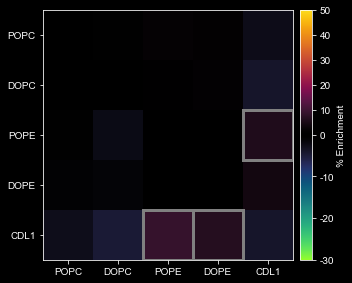

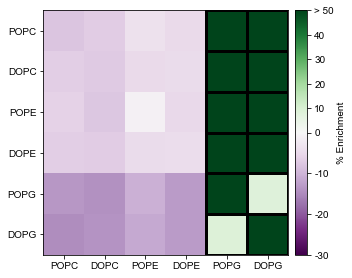

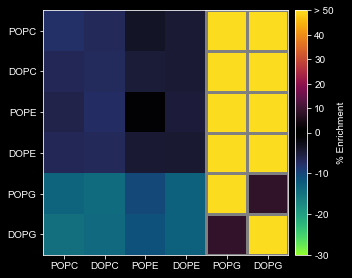

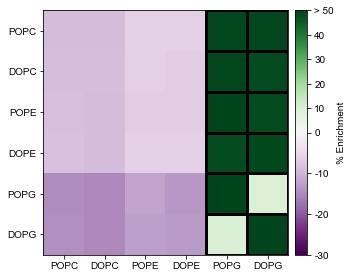

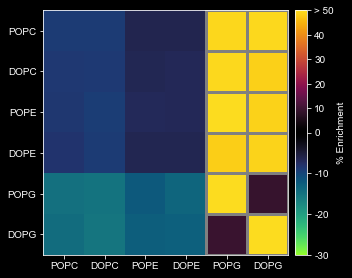

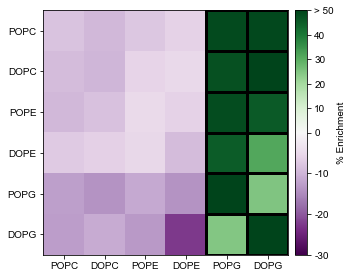

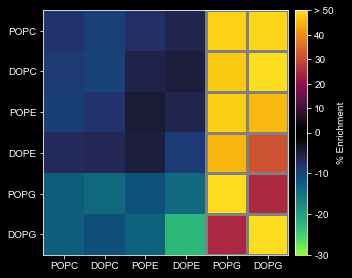

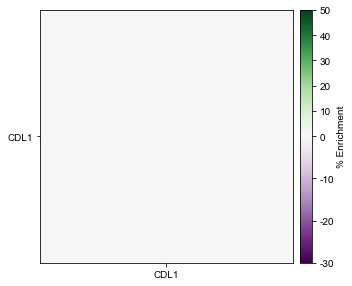

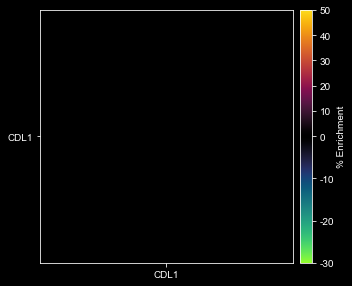

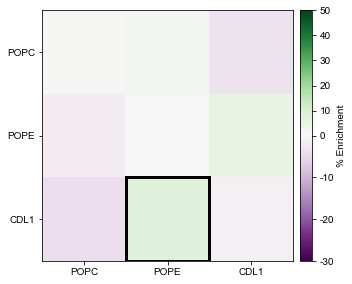

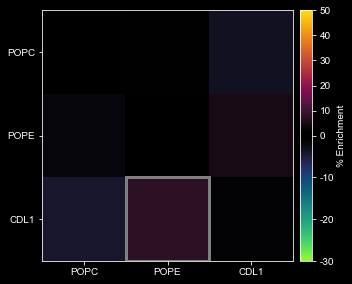

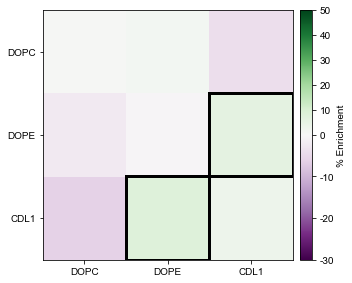

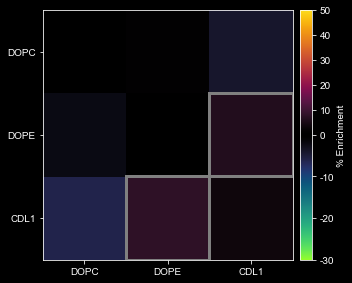

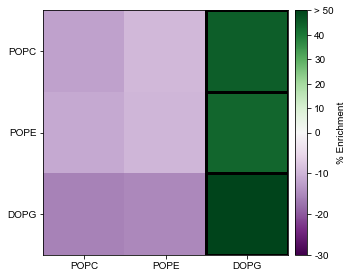

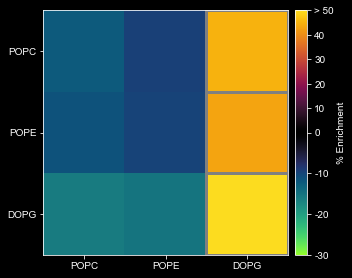

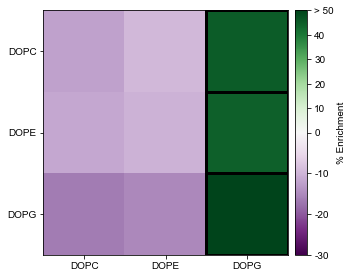

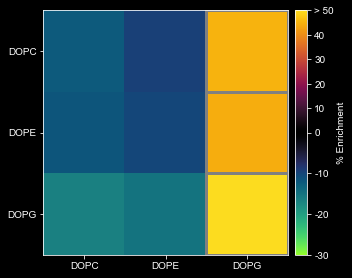

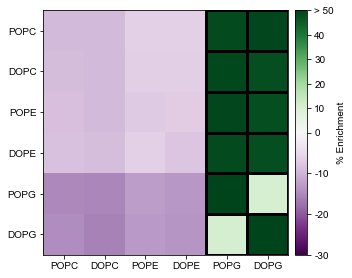

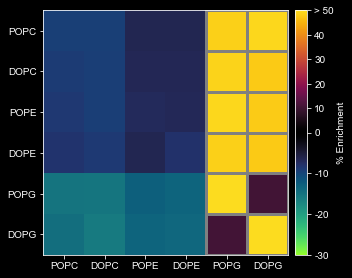

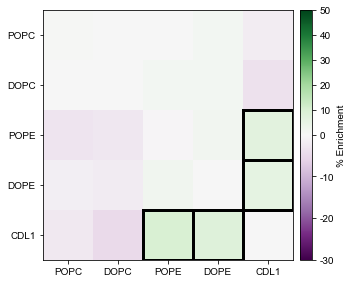

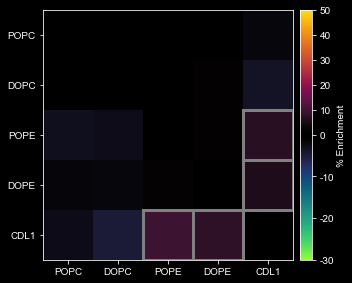

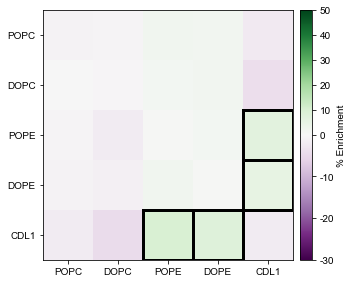

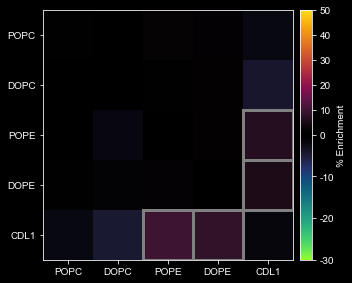

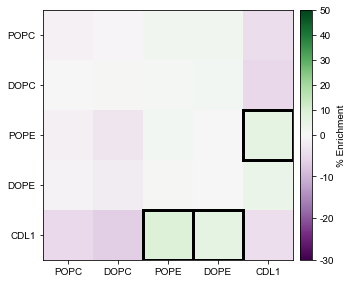

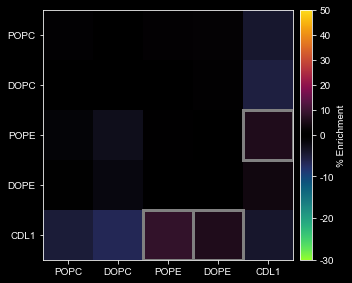

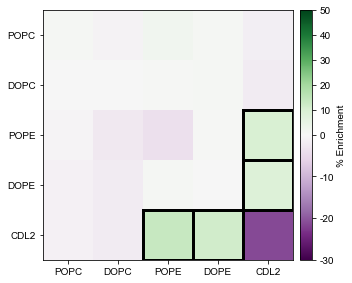

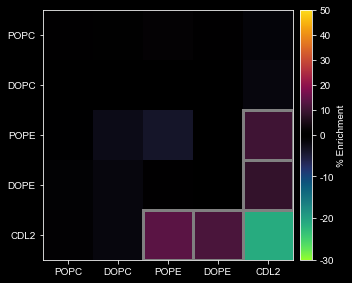

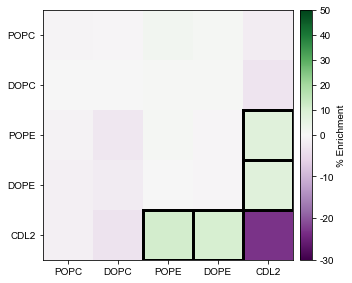

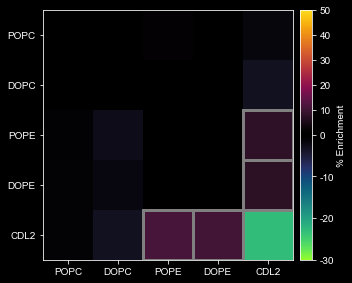

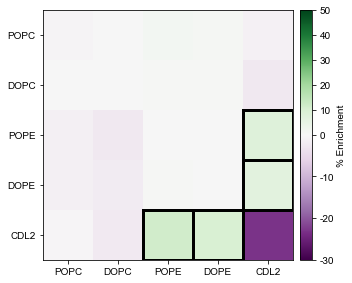

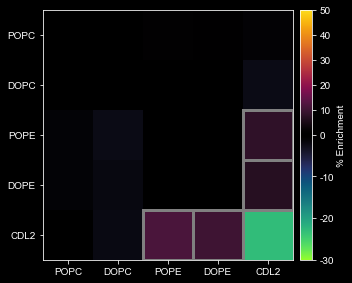

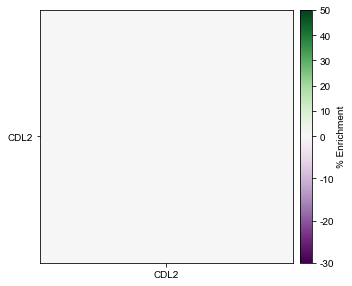

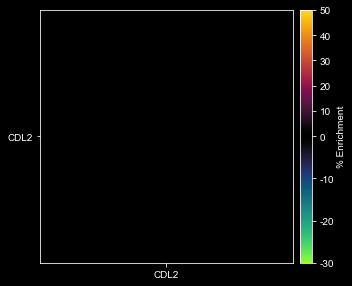

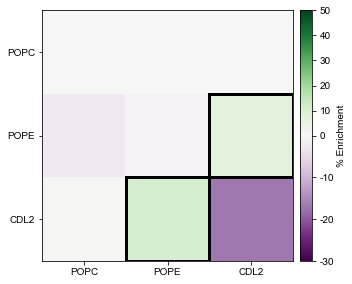

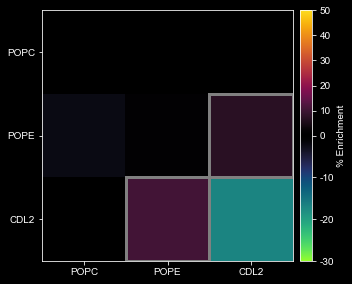

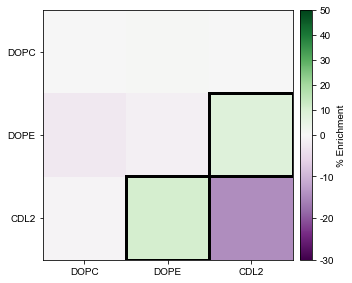

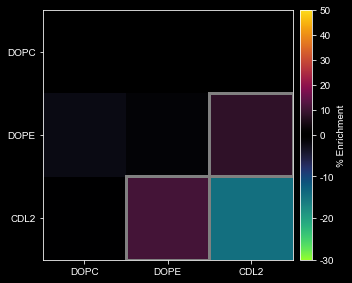

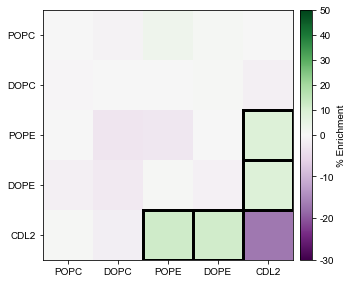

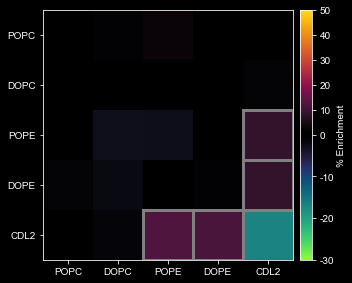

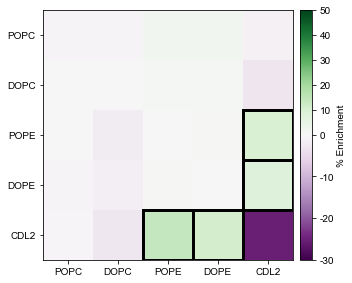

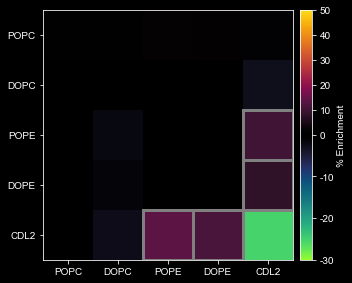

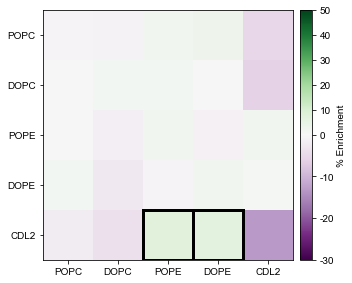

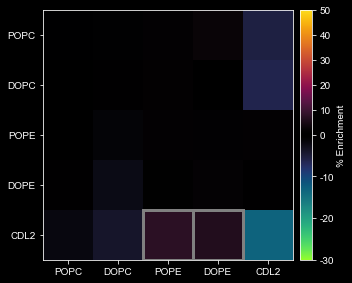

In [44]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

show_figs = True
curr_fig_path = Path("Figures/neighborhood/")
curr_fig_path.mkdir(parents=True, exist_ok=True)

vmin = 0.7
vmax = 1.5

box_threshold = 1.05

dataset = neighbor_enrichment

for sim in util.simulations:
    # print(f"System {util.sim_to_final_index[sim]}: {util.system_names[sim]}")

    raw_baseline = []
    baseline = []
    s = ""
    for lipid in lipids:
        if lipid in compositions[sim, "raw_composition"]:
            # div by 2 to account for leaflet composition
            raw_baseline.append(compositions[sim, "raw_composition"][lipid] / 2)
        else:
            raw_baseline.append(0)
        s += f"{lipid}: {compositions[sim, 'normed_composition'][lipid]:0.3f}, "
        baseline.append(compositions[sim, "normed_composition"][lipid])
    raw_baseline = np.array(raw_baseline).reshape(-1, 1)  # COLUMN VECTOR
    # print(s)
    # fraction of each lipid per leaflet
    baseline = np.array(baseline)
    # print(raw_baseline, baseline)

    # Aggregate statistics from both leaflets
    counts_per_frame = (dataset[sim]["upper"] + dataset[sim]["lower"]) / 2
    # Keep only back half of trajectory
    N = int(0.5 * len(counts_per_frame))
    counts = np.mean(counts_per_frame[N:-1], axis=0)  # mean counts per frame

    # Copy counts across diagonal which must be symmetric
    for i in range(0, len(lipids)):
        for j in range(0, i):
            counts[i, j] = counts[j, i]
        counts[i, i] *= 2
    counts /= 2

    # print(pd.DataFrame(counts, columns=lipids, index=lipids))

    # Normalize by number of each lipid within leaflet
    # ROWWISE DIVISION...
    normed_counts = np.divide(
        counts, raw_baseline, out=np.zeros_like(counts), where=raw_baseline != 0
    )
    df_normed_counts = pd.DataFrame(normed_counts, columns=lipids, index=lipids)
    # df_normed_counts.to_csv(f"sheets/sim_{util.sim_to_final_index[sim]}_nlipids_{prefix}.csv")

    # print("# of each lipid around row lipid\n", df_normed_counts)

    rowwise_sum = np.sum(normed_counts, axis=1).reshape(-1, 1)
    # print(np.array2string(rowwise_sum, max_line_width=np.inf))

    likelihood_count = np.divide(
        normed_counts,
        rowwise_sum,
        out=np.zeros_like(counts),
        where=rowwise_sum != 0,
    )

    # print(np.array2string(likelihood_count, max_line_width=np.inf))

    diff_counts = np.divide(
        likelihood_count,
        baseline,
        out=np.zeros_like(normed_counts),
        where=baseline != 0,
    )
    # df = pd.DataFrame(normed_counts, columns=lipids, index=lipids)
    # print(df)

    # print("DIFF:")
    df_diff = pd.DataFrame(pd.DataFrame(diff_counts, columns=lipids, index=lipids))
    df_diff = df_diff.loc[:, (df_diff != 0).any(axis=0)]
    df_diff = df_diff.loc[(df_diff != 0).any(axis=1)]

    for style, style_ext in plot_styles:
        with plt.style.context(style):
            if style_ext:
                ecolor = "gray"
                # cmap = sns.diverging_palette(
                #     291, 144, s=100, l=50, center="dark", as_cmap=True
                # )
                # cmap = sns.color_palette("icefire", as_cmap=True)
                cmap = plt.get_cmap('cmr.wildfire')
            else:
                ecolor = "black"
                cmap = "PRGn"

            # print(df_diff.to_numpy().max(), df_diff.to_numpy().min())
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.1)

            im = ax.imshow(
                df_diff,
                cmap=cmap,
                norm=mpl.colors.TwoSlopeNorm(vmin=vmin, vcenter=1.0, vmax=vmax),
            )

            box_table = (df_diff > box_threshold).to_numpy()
            nx, ny = box_table.shape
            for i in range(nx):
                for j in range(ny):
                    if box_table[i, j]:
                        highlight_cell(j, i, ax=ax, color=ecolor, linewidth=3)

            cb = fig.colorbar(im, cax=cax, orientation="vertical")

            ticks = cb.get_ticks()

            ticklabels = [r"{:0.0f}".format((tick - 1) * 100) for tick in ticks]

            if df_diff.to_numpy().max() > vmax:
                ticklabels[-1] = "> " + ticklabels[-1]

            if df_diff.to_numpy().max() < vmin:
                ticklabels[0] = "< " + ticklabels[0]

            cb.set_ticks(ticks)
            cb.set_ticklabels(ticklabels)
            # cb.ax.tick_params(labelsize=14)
            cb.set_label("% Enrichment")

            ax.set_xticks(range(len(df_diff)), df_diff.columns)
            ax.set_yticks(range(len(df_diff)), df_diff.index)

            fig.tight_layout()

            save_fig(
                fig,
                curr_fig_path
                / f"Sys{util.sim_to_final_index[sim]}_likelihood{style_ext}",
            )

            if show_figs:
                plt.show()

            fig.clear()
            plt.close(fig)


In [ ]:
print_neighbor_analysis(neighbor_enrichment, prefix="15A")


System 1: +CL1; 0S
POPC: 0.120, DOPC: 0.460, POPE: 0.030, DOPE: 0.270, CDL1: 0.120, CDL2: 0.000, POPG: 0.000, DOPG: 0.000, 
# of each lipid around row lipid
       POPC  DOPC  POPE  DOPE  CDL1  CDL2  POPG  DOPG
POPC 1.021 3.938 0.260 2.367 1.009 0.000 0.000 0.000
DOPC 1.026 3.930 0.261 2.349 0.986 0.000 0.000 0.000
POPE 1.040 4.003 0.269 2.414 1.147 0.000 0.000 0.000
DOPE 1.050 4.000 0.268 2.396 1.114 0.000 0.000 0.000
CDL1 1.009 3.782 0.287 2.511 1.033 0.000 0.000 0.000
CDL2 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
POPG 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
DOPG 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
Enrichment from likelihood:
       POPC  DOPC  POPE  DOPE  CDL1  CDL2  POPG  DOPG
POPC 0.991 0.996 1.010 1.019 0.979 0.000 0.000 0.000
DOPC 1.001 0.999 1.017 1.017 0.961 0.000 0.000 0.000
POPE 0.978 0.981 1.012 1.007 1.078 0.000 0.000 0.000
DOPE 0.992 0.985 1.012 1.004 1.053 0.000 0.000 0.000
CDL1 0.976 0.954 1.109 1.078 0.999 0.000 0.000 0.000
CDL2 0.000 0.000 0

In [ ]:
voronoi = {}

for sim in util.simulations:
    with open(util.analysis_path / f"{sim}/voronoi_leaflet_glo.pickle", "rb") as handle:
        voronoi[sim] = pickle.load(handle)


In [ ]:
print_neighbor_analysis(voronoi, prefix="voronoi")


System 1: +CL1; 0S
POPC: 0.120, DOPC: 0.460, POPE: 0.030, DOPE: 0.270, CDL1: 0.120, CDL2: 0.000, POPG: 0.000, DOPG: 0.000, 
# of each lipid around row lipid
       POPC  DOPC  POPE  DOPE  CDL1  CDL2  POPG  DOPG
POPC 0.359 1.394 0.088 0.799 0.357 0.000 0.000 0.000
DOPC 0.363 1.401 0.088 0.797 0.350 0.000 0.000 0.000
POPE 0.350 1.350 0.087 0.775 0.394 0.000 0.000 0.000
DOPE 0.355 1.358 0.086 0.774 0.383 0.000 0.000 0.000
CDL1 0.357 1.344 0.099 0.864 0.376 0.000 0.000 0.000
CDL2 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
POPG 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
DOPG 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
Enrichment from likelihood:
       POPC  DOPC  POPE  DOPE  CDL1  CDL2  POPG  DOPG
POPC 0.999 1.011 0.974 0.987 0.995 0.000 0.000 0.000
DOPC 1.010 1.015 0.978 0.984 0.974 0.000 0.000 0.000
POPE 0.988 0.993 0.977 0.971 1.113 0.000 0.000 0.000
DOPE 1.001 0.999 0.971 0.969 1.082 0.000 0.000 0.000
CDL1 0.981 0.961 1.082 1.052 1.031 0.000 0.000 0.000
CDL2 0.000 0.000 0